<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/2_SimpleODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem : **DE Solver**

## Differential Equation

Differential squation is
$$\frac{dy}{dx}=cos(x)$$
with *Boundary Conditions*
$$y(0)=y(2\pi)=0$$
and *Theoritical Solution*
$$y(x)=sin(x)$$

## **Import** *Libraries*

In [328]:
 ! pip install pyDOE

In [329]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


## **DEF** *Function*

In [330]:
def dfdx(x):
  return torch.cos(x)

def f_BC(x_BC):
  return torch.sin(x_BC)

def f_Theory(x):
  return torch.sin(x)

## **DEF** *Neural Network*

The residual will be:
$$f_{DE}=y_x-cos(x)$$
$$f_{BC}=y(x_{BC}) - y_{BC}$$
$$f = f_{DE} + f_{BC}$$

In [331]:
class FCN(nn.Module):

    'Neural Network'
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(x_train,y_train)
        loss.backward() 
        self.iter += 1
        if self.iter % 100 == 0:
            print(loss)
        return loss

    'Loss Functions'
    #Loss Boundary Condition
    def lossBC(self,x_BC):
      loss_BC=self.loss_function(self.forward(x_BC),f_BC(x_BC))
      return loss_BC

    #Loss Differential Equation
    def lossDE(self,x_DE):
      g=x_DE.clone()
      g.requires_grad=True 
      #Enable differentiation
      f=self.forward(g)
      f_x=autograd.grad(f,g,torch.ones([x_DE.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
      # Gradient of f with respect to x_DE
      loss_DE=self.loss_function(f_x,dfdx(g))
      return loss_DE
      # f_x  is df/dx in numerical
      # dfdx is df/dx from DE
      
    def loss(self,x_BC,x_DE):
      loss_bc=self.lossBC(x_BC)
      loss_de=self.lossDE(x_DE)
      return loss_bc+loss_de

## **DEF** *Tunning Parameters*

In [332]:
steps=5000
lr=1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers

#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nu=2
Nf=250

## Generate data

生成数据集(理论公式)

In [333]:
nx=500

min=0
max=2*np.pi
x = torch.linspace(min,max,nx).view(-1,1) #prepare to NN
yx = dfdx(x)
y0 = f_Theory(x)

检查数据集，画x-y图

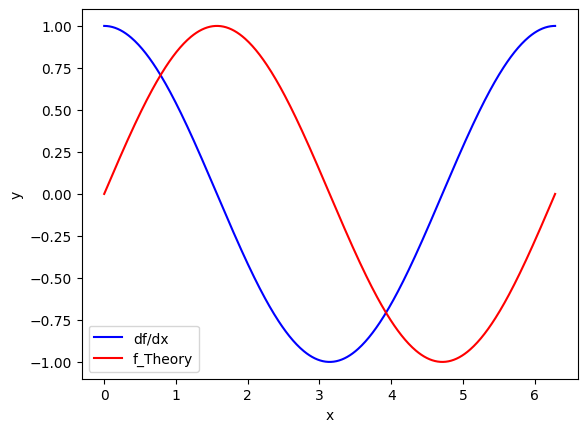

In [334]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),yx.detach().numpy(),color='blue',label='df/dx')
ax1.plot(x.detach().numpy(),y0.detach().numpy(),color='red',label='f_Theory')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('y',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'lower left')

## Train Neural Network

### 生成训练、测试数据集

Boundary Conditions Data

In [335]:
#def get_training_data(x):
#Nu: Number of training point, # Nf: Number of colloction points
# Set Boundary conditions:
BC_1=x[0,:]
BC_2=x[-1,:]
# Total Training points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_DE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_DE = torch.vstack((x_DE,x_BC))

x_DE=x_DE.float().to(device)
x_BC=x_BC.to(device)

### 生成神经网络模型

In [336]:
model = FCN(layers)
model.to(device)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)

### 选择优化算法

In [337]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)

### 核心迭代

In [338]:
torch.manual_seed(123)
#产生一个随机数
start_time = time.time()

for i in range(steps):
    optimizer.zero_grad()
    yh = model(x_DE)
    loss = model.loss(x_DE,x_BC)
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(1.5091, grad_fn=<AddBackward0>)


tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(8.6149e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.0915e-05, grad_fn=<AddBackward0>)
tensor(2.1223e-05, grad_fn=<AddBackward0>)
tensor(1.3719e-05, grad_fn=<AddBackward0>)
tensor(1.0690e-05, grad_fn=<AddBackward0>)


### 输出模型预测结果

生成输出网格

In [339]:
min=0
max=2*np.pi
total_points=371

xP = torch.linspace(min,max,total_points).view(-1,1)

画出函数图x-model(x)和x-f(x)

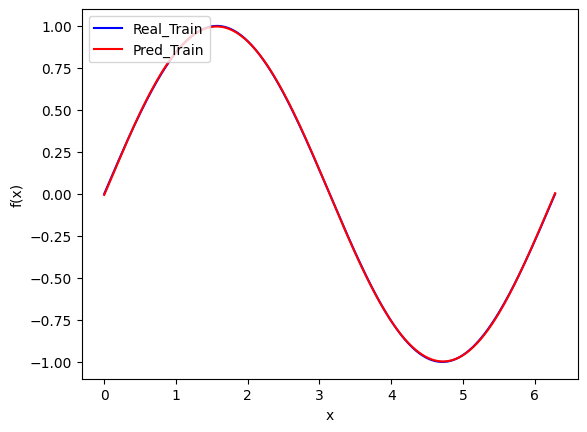

In [340]:
fig, ax1 = plt.subplots()
ax1.plot(xP.detach().numpy(),f_Theory(xP).detach().numpy(),color='blue',label='Real_Train')
ax1.plot(xP.detach().numpy(),model(xP).detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

画出误差图x-[model(x)-f(x)]

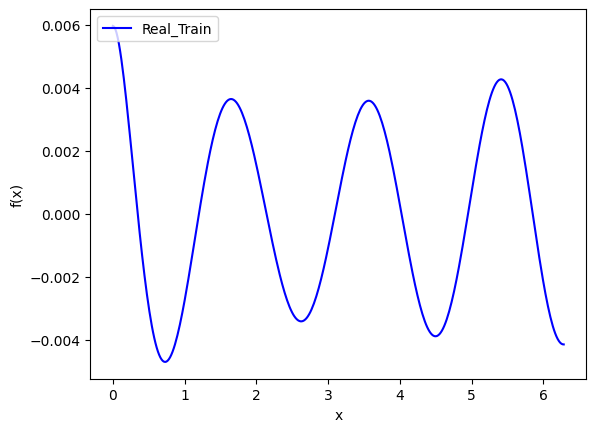

In [342]:
fig, ax1 = plt.subplots()
ax1.plot(xP.detach().numpy(),(f_Theory(xP)-model(xP)).detach().numpy(),color='blue',label='Real_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')